## Load and parse PDFs

# Section 1: Setup and Dependencies

In [ ]:
!pip install -qU llama-index-postprocessor-flag-embedding-reranker git+https://github.com/FlagOpen/FlagEmbedding.git
!pip install -qU llama-index
!pip install transformers accelerate bitsandbytes
!pip install llama-index-llms-huggingface
!pip install llama_index.llms.openai
!pip install llama-index-embeddings-huggingface
import torch

provide a API keys to continue

In [ ]:
import os
import getpass

os.environ["LLAMA_CLOUD_API_KEY"] = getpass.getpass("LLamaParse API Key:")
os.environ["HF_TOKEN"] = getpass.getpass("HF API Key:")
os.environ["OPENAI_API_KEY"] = getpass.getpass("Open AI Key:")

Import

In [ ]:
# Make sure we can run async in our Colab instance
import nest_asyncio

nest_asyncio.apply()

In [ ]:
#result_type - at time of writing this notebook the options are limited to "text" and "markdown".
#Markdown will be our choice as it will retain structured information quite nicely.
#num_workers - this will let us set how many workers we'll need.
#Generally we'll want to set this to the number of files we're going to need to parse. (the maximum is 10)
# NOTE: As of time of writing, only .pdf files are accepted

from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
    verbose=True,
    language="en",
    num_workers=2,
)

In [ ]:
from llama_index.core import SimpleDirectoryReader
file_extractor = {".pdf": parser}
documents = SimpleDirectoryReader(
    "/content/PDF", file_extractor=file_extractor
).load_data()

Started parsing the file under job_id f0da4728-7eab-414a-bce6-28151dd23f32
.

In [ ]:
# example of parsed document, is readable in Markdown
# check how it looks on the markdown.preview website
print(documents[0].text[:1000])

|Abschnitt / Part|Inhalt / Content|Abteilung / Department|Ansprechpartner / Contact person|Verhandelbar / Negotiable|Nicht verhandelbar / Non-Negotiable|Anfragespezifisch / Dependent|Anmerkungen / Comments|Fragen / Questions|
|---|---|---|---|---|---|---|---|---|
|0|Preliminary remarks|Beschaffung / Purchasing|LEB| | | |Mehrmarkenvergabe / Multi brand inquiry| |
|1|Subject matter of the contract| | | | | | | |
|1.1|Beauftragung / Entrust|Beschaffung / Purchasing|LEB|x| | | | |
|1.2|Kosten / Costs|Beschaffung / Purchasing|LEB| | | | | |
|1.3|Produktionsstandort(e) / Production facility/facilities|Beschaffung / Purchasing|LEB| | | | | |
|1.4|Kapazitäten / Capacities|Beschaffung / Purchasing|LEB| | | | | |
|1.5|Bemis, Änderungen, Wartung / Operating Equipment, Changes, Maintenance|Beschaffung / Purchasing|LEB|x| | |Wenn keine Werkzeuge beauftragt werden, kann der Abschnitt angepasst werden.| |
|1.6|Prototypen / Prototypes|Engineering|BTV| | |x|Wenn keine Prototypen beauftragt werden, kann

# Section 2: Creating Embeddings and Models

In [ ]:
# Settings of the model and. embeddings type
from llama_index.llms.huggingface import HuggingFaceLLM
from transformers import BitsAndBytesConfig
from llama_index.core.prompts import PromptTemplate



quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

def messages_to_prompt(messages):
  prompt = ""
  for message in messages:
    if message.role == 'system':
      prompt += f"<|system|>\n{message.content}</s>\n"
    elif message.role == 'user':
      prompt += f"<|user|>\n{message.content}</s>\n"
    elif message.role == 'assistant':
      prompt += f"<|assistant|>\n{message.content}</s>\n"

  # ensure we start with a system prompt, insert blank if needed
  if not prompt.startswith("<|system|>\n"):
    prompt = "<|system|>\n</s>\n" + prompt

  # add final assistant prompt
  prompt = prompt + "<|assistant|>\n"

  return prompt


llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    generate_kwargs={"temperature": 0.0, "top_k": 50, "top_p": 0.95},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)

from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/11 [04:17<?, ?it/s]
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-194' coro=<tqdm_asyncio.gather.<locals>.wrap_awaitable() done, defined at /usr/local/lib/python3.10/dist-packages/tqdm/asyncio.py:75> exception=RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-jGTrXzBcdYyp6ZPG52kWu4qy on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}")>
Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/usr/local/lib/python3.10/dist-packages/tqdm/asyncio.py", line 76, in wrap_awaitable
    return i, await f
  

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-3.5-turbo", temperature=0)

from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Download the markdown parser
from llama_index.core.node_parser import MarkdownElementNodeParser

node_parser = MarkdownElementNodeParser(llm=llm, num_workers=8)

In [ ]:
# let's parse
#nodes = node_parser.get_nodes_from_documents(documents)
nodes = node_parser.get_nodes_from_documents(documents)

11it [00:00, 10198.35it/s]
  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/llama_index/core/program/utils.py:58: UserWarning: Failed to use `OpenAIPydanticProgram`. Please ensure that is installed by running `pip install llama-index-program-openai`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
__root__
  Expecting ',' delim

In [ ]:
# Now we can extract our `base_nodes` and `objects` to create our `VectorStoreIndex`
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)


In [ ]:
# Let's build the index!
from llama_index.core import VectorStoreIndex

recursive_index = VectorStoreIndex(nodes=base_nodes+objects)

# Section 3: Saving and Loading the Database


[See this article](https://medium.com/@reddyyashu20/llamaindex-create-save-load-indexes-customize-llms-prompts-embeddings-abb581df6dac)

In [ ]:
save_dir="./myvector_store/newindex"
# create and load the index
# Persist index to disk
recursive_index.storage_context.persist(persist_dir=save_dir)

the vector store is located here:
Google drive

In [ ]:
from llama_index.core import StorageContext, load_index_from_storage
#LLAMA API
#HF API
#LLM model
#embed model
# Rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="/content/vectors")

# Load index from the storage context
new_index = load_index_from_storage(storage_context)


# Let's do a simple test
# Create a query engine from the index
new_query_engine = new_index.as_query_engine()
response = new_query_engine.query("why should i choose MAN?")
print(response)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00


ValueError: 
******
Could not load OpenAI embedding model. If you intended to use OpenAI, please check your OPENAI_API_KEY.
Original error:
No API key found for OpenAI.
Please set either the OPENAI_API_KEY environment variable or openai.api_key prior to initialization.
API keys can be found or created at https://platform.openai.com/account/api-keys

Consider using embed_model='local'.
Visit our documentation for more embedding options: https://docs.llamaindex.ai/en/stable/module_guides/models/embeddings.html#modules
******

## Recursive Query Engine

Now we can build our Recursive Query Engine with reranking

In [ ]:
import locale
# Storing the original function
original_getpreferredencoding = locale.getpreferredencoding

# Restoring the original function
locale.getpreferredencoding = original_getpreferredencoding

In [ ]:
# Modifying the lambda to accept an unused argument
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from llama_index.postprocessor.flag_embedding_reranker import FlagEmbeddingReranker

reranker = FlagEmbeddingReranker(
    top_n=5,
    model="BAAI/bge-reranker-large",
)

recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=15,
    node_postprocessors=[reranker],
    verbose=True
)

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [ ]:
query = "which department should contact for issues related to Capacity content?"
response = recursive_query_engine.query(query)

Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_6_table: TextNode
Retrieving from object TextNode with query which department should contact for issues related to Capacity content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_4_table: TextNode
Retrieving from object TextNode with query which department should contact for issues related to Capacity content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_0_table: TextNode
Retrieving from object TextNode with query which department should contact for issues related to Capacity content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_12_table: TextNode
Retrieving from object TextNode with query which department should contact for issues related to Capacity content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_20_table: TextNode
Retrieving from object TextNode with query which department should contact for issues related to Capacity content?
Retrieval entering id_297a1584-bab1-4d

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(response)

The department that should be contacted for issues related to Capacity content is the Beschaffung / Purchasing department (LEB) as it is mentioned in the table "Preliminary Remarks and Specifications for Potential Contract between LEB and BTV" under the section "Produktionsstandort(e) / Production facility/facilities".


In [ ]:
query = "who are the contact persons for the Supply Subject matter of the content?"
response = recursive_query_engine.query(query)

Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_0_table: TextNode
Retrieving from object TextNode with query who are the contact persons for the Supply Subject matter of the content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_30_table: TextNode
Retrieving from object TextNode with query who are the contact persons for the Supply Subject matter of the content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_2_table: TextNode
Retrieving from object TextNode with query who are the contact persons for the Supply Subject matter of the content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_4_table: TextNode
Retrieving from object TextNode with query who are the contact persons for the Supply Subject matter of the content?
Retrieval entering id_297a1584-bab1-4d2e-93a1-1fe24dbaf47f_6_table: TextNode
Retrieving from object TextNode with query who are the contact persons for the Supply Subject matter of the content?
Retrieval entering id_297a158

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(response)

The contact person for the Supply Subject matter is not explicitly mentioned in the given context information. However, it can be inferred that the contact person for the Supply Subject matter is likely to be the department or person responsible for procurement and purchasing, which is LEB (Lebensmittelbereich) in this case.


In [ ]:
query = "How do I get access to FIN?"
response = recursive_query_engine.query(query)

Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_2_table: TextNode
Retrieving from object TextNode with query How do I get access to FIN?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_28_table: TextNode
Retrieving from object TextNode with query How do I get access to FIN?
Retrieval entering id_6d1cfba8-b8ed-45c2-b9c8-b23727137921_6_table: TextNode
Retrieving from object TextNode with query How do I get access to FIN?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(response)

To get access to FIN, you need to have a DUNS number. If you don't have one, you can request it on the site: https://www.upik.de/en/dunsanfordern.html. Once you have a DUNS number, you need to register on the Volkswagen Group ONE.Konzern Business Platform and set up your user account with the Company Admin. The Company Admin is responsible for setting up new user accounts and giving permissions to employees from your company. For more information, see the User Manual - User management system.


In [ ]:
query = "How to check your vendor number?"
response = recursive_query_engine.query(query)
print(response)

Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_28_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_24_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_22_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_4_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_2_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_6d1cfba8-b8ed-45c2-b9c8-b23727137921_48_table: TextNode
Retrieving from object TextNode with query How to check your vendor number?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_0_table: TextNode
R

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The vendor number can be found on the documents you receive from MAN, such as payment advice, debit note, order, request for payment, etc. If you have problems determining the number, you can contact vendor.support@man.eu for assistance.


Answer: The number is given on the documents you receive from MAN: payment advice, debit note, order, request for payment, etc. In case of problems with determining the number, please contact vendor.support@man.eu


In [ ]:
query = "How to check the debit note number?"
response = recursive_query_engine.query(query)
print(response)

Retrieval entering id_d3a47cca-39ca-4397-82a3-9a1ac3fdb256_12_table: TextNode
Retrieving from object TextNode with query How to check the debit note number?
Retrieval entering id_6d1cfba8-b8ed-45c2-b9c8-b23727137921_66_table: TextNode
Retrieving from object TextNode with query How to check the debit note number?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The debit note number is included on the documents sent to your company by MAN. It is a 10-digit number (FI-Belegnummer). Depending on the MAN company, the number of the debit note starts with the numbers shown below:

- MAN Truck & Bus SE, Germany (Munich, Salzgitter, Dachau, Nuernberg): 6030*
- MAN Truck & Bus Deutschland GmbH, Germany (Munich): 5700*
- MAN Truck & Bus SE, Germany (Steyr) / Old: MAN Truck & Bus Österreich GesmbH, Austria (Steyr): 5500*
- MAN Bus Sp. z o.o., Poland (Starachowice) NIP: PL5342082736: 2150*
- MAN Trucks Sp. z o.o., Poland (Niepolomice) NIP: 5262851977: 5200*
- MAN Truck & Bus Polska Sp. z


Answer: The number is included on the document sent to your company. It is a 10-digit number (FI-Belegnummer). Depending on the MAN company, the number of the debit note starts with the numbers shown below:
MAN Truck & Bus SE, Germany (Munich, Salzgitter, Dachau, Nuernberg) =6030* MAN Truck & Bus Deutschland GmbH, Germany (Munich)= 5700*
MAN Truck & Bus SE, Germany (Steyr) / Old: MAN Truck & Bus Österreich GesmbH, Austria (Steyr) = 5500*
MAN Bus Sp. z o.o., Poland (Starachowice) NIP: PL5342082736= in 2021 to 2122*, in 2022 to 2222*, etc.
MAN Trucks Sp. z o.o., Poland (Niepolomice) NIP: PL5262851977=2150*
MAN Truck & Bus Polska Sp. z o.o., Poland (Nadarzyn) NIP:5342169325=5200*

In [ ]:
query = "I hope this email finds you well. As one of our valued partners in the automotive industry, we strive to ensure seamless communication and collaboration between our companies. In this regard, we would like to inquire about the process for verifying our debit note  number with your esteemed company. Could you please provide guidance on how to check our vendor number within your system? Ensuring the accuracy of our vendor information is crucial for smooth transactions and efficient business operations. Your assistance in this matter would be greatly appreciated. If there are any specific documents or procedures we need to follow, please do not hesitate to inform us. Thank you for your attention to this matter. We look forward to your prompt response. Best regards,Sam"
response = recursive_query_engine.query(query)
print(response)

Retrieval entering id_d3a47cca-39ca-4397-82a3-9a1ac3fdb256_12_table: TextNode
Retrieving from object TextNode with query I hope this email finds you well. As one of our valued partners in the automotive industry, we strive to ensure seamless communication and collaboration between our companies. In this regard, we would like to inquire about the process for verifying our debit note  number with your esteemed company. Could you please provide guidance on how to check our vendor number within your system? Ensuring the accuracy of our vendor information is crucial for smooth transactions and efficient business operations. Your assistance in this matter would be greatly appreciated. If there are any specific documents or procedures we need to follow, please do not hesitate to inform us. Thank you for your attention to this matter. We look forward to your prompt response. Best regards,Sam
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_28_table: TextNode
Retrieving from object Te

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Dear Sam,

Thank you for your email and for your interest in our company. To check your vendor number within our system, please refer to the documents you receive from us, such as payment advice, debit note, order, request for payment, etc. If you encounter any difficulties in determining your vendor number, please contact us at vendor.support@man.eu.

Regarding the verification of your debit note number, please select the category "request copy (debit note / payment advice)" in the Vendor Portal. This category allows you to request a copy of the debit note, which will contain the debit note number. If you have any questions or concerns regarding this process, please do not hesitate to contact us.

We appreciate your partnership and look forward to continuing to work with you.

Best regards,

The Vendor Portal Team


"Could you please provide guidance on how to check our vendor number within your system?"

```
# This is formatted as code
```



In [ ]:
query = "Could you please provide guidance on how to check our vendor number within your system?"
response = recursive_query_engine.query(query)
print(response)

Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_28_table: TextNode
Retrieving from object TextNode with query Could you please provide guidance on how to check our vendor number within your system?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_4_table: TextNode
Retrieving from object TextNode with query Could you please provide guidance on how to check our vendor number within your system?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_2_table: TextNode
Retrieving from object TextNode with query Could you please provide guidance on how to check our vendor number within your system?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_24_table: TextNode
Retrieving from object TextNode with query Could you please provide guidance on how to check our vendor number within your system?
Retrieval entering id_e7463c07-9460-4e79-98d0-9190791a255d_0_table: TextNode
Retrieving from object TextNode with query Could you please provide guidance on how to ch

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To check your vendor number within our system, please refer to the documents you receive from MAN, such as payment advice, debit note, order, request for payment, etc. The number is given on these documents. If you encounter any problems determining the number, please contact vendor.support@man.eu for assistance.


In [ ]:
query = "Where the cost center G8033 is located?"
response = recursive_query_engine.query(query)
print(response)

Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_20_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_28_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_2_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_32_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_24_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79-4dfc-8dc3-29168d4b2cc9_30_table: TextNode
Retrieving from object TextNode with query Where the cost center G8033 is located?
Retrieval entering id_d7df96ad-6d79

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The cost center G8033 is located in Flensburg, Germany, which is part of the SC-D-1 distribution region. This information can be found in the table provided in the context information. The table lists distribution regions, locations, and cost centers for various cities in Germany. The cost center G8033 is located in the city of Flensburg, which is listed in the table with the following information:

|Distribution region|Mark|Location|Cost Center|Zip code|City|Street|
|---|---|---|---|---|---|---|
|SC-D-1 Südost|SB|SB Flensburg|G8033|G8981|Flensburg|Lise-Meitner-Str. 27|

The table also provides the zip code (G8981) and street address (Lise-Meitner-Str. 27) for this location.


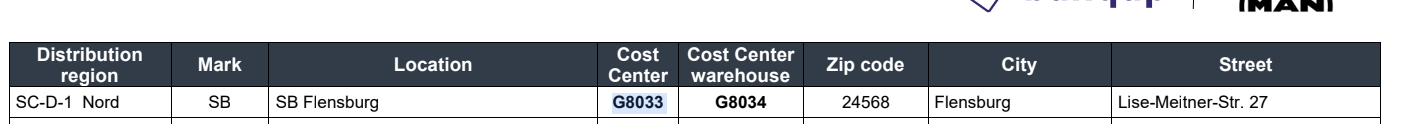